In [80]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=f'{0}'

import torch

import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import re
from scipy.interpolate import LinearNDInterpolator

from modules import torch_util, dataHandler, dataprocessing
from modules import (
    models as m,
    scalers as scaling
)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
    print(torch.cuda.current_device())
else:
    print("cpu")
    device = torch.device("cpu")

cuda
0


## The following section can be skipped if all the scalers where saved doing training, but forgot to implement that

In [3]:
# Load all data
(
    regions,
    ts_profiles,
    bathymetri_lat, bathymetri_lon, bathymetri_topography,
    ghrsst_lat, ghrsst_lon, ghrsst_sst, ghrsst_times, ghrsst_fraction_time, ghrsst_time_bnds,
    smos_sss, smos_time, smos_lat, smos_lon
) = dataHandler.load_all(verbose=True)
ts_areas = dataprocessing.split_regions(ts_profiles, regions.set_crs(4326))
min_time, max_time = min(ghrsst_fraction_time), max(ghrsst_fraction_time)
training_end = 2012
validation_end = 2015
train, val, test, areas = dataprocessing.split_data_set(ts_areas, training_end, validation_end, min_time, max_time)

/zhome/ae/4/138518/Desktop/Special_kursus/dataHandler.py:359: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  bathymetri_topography: np.ndarray = bathymetri['bedrock_topography'][:].data[bathymetri_lat > 60, :]
/zhome/ae/4/138518/Desktop/Special_kursus/dataHandler.py:359: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  bathymetri_topography: np.ndarray = bathymetri['bedrock_topography'][:].data[bathymetri_lat > 60, :]


/zhome/ae/4/138518/Desktop/Special_kursus/dataprocessing.py:18: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  points = gp.GeoDataFrame(ts_profiles.point, columns=['geometry']).set_crs(4326)
/zhome/ae/4/138518/Desktop/Special_kursus/dataHandler.py:249: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([getattr(profile, __name) for profile in self.profiles], dtype=self.__get_type(out))
/zhome/ae/4/138518/Desktop/env/lib/python3.9/site-packages/IPython/core/interactiveshell

In [58]:
get_scalers = lambda:  [
    scaling.MeanScaling, # lat
    scaling.MeanScaling, # lon
    scaling.MeanScaling, # year
    scaling.MeanScaling, # decimal year
    scaling.MeanScaling, # sss
    scaling.MeanScaling, # sst
    scaling.MeanScaling, # surface depth
    scaling.MinMaxScaling, # bathymetri
    scaling.MeanScaling, # salinity profile
    scaling.MeanScaling, # temperature profile
]
saved_scalers = torch_util.Dict()
scaler_names = ['lat', 'lon', 'year', 'decimal_year', 'sss', 'sst', 'depth', 'bathymetri', 'salinity', 'temperature']
bathymetri_data = [bathymetri_lat, bathymetri_lon, bathymetri_topography]
for area in ['North Atlantic', 'Beaufort Sea', 'Laptev Sea']:
    print(area)
    max_length = train[area].profile_length.max()
    s = torch_util.fit_scalers(train[area], max_length, get_scalers(), *bathymetri_data)
    saved_scalers[area] = torch_util.Dict(zip(scaler_names, s))

## Get chosen profiles and interpolate sss and sst to chosen points

In [59]:
profiles = {}
with ZipFile("data/comp_prof_intp.zip", 'r') as archive:
    files = archive.filelist
    for file in files:
        if not file.filename.endswith('.dat'):
            continue
        match = re.search('[0-9]{1,}', file.filename)
        if match is None:
            continue
        profile_id = int(match.group(0))
        
        save_data = []
        data = archive.read(file).decode().split('\n')
        for line in data:
            if line == '':
                continue
            save_data.append([])
            for c in line.split(','):
                save_data[-1].append(float(c))
        if profile_id not in profiles:
            profiles[profile_id] = {}
        if file.filename.count('intp') == 2:
            profiles[profile_id]['intp'] = np.array(save_data)
        else:
            profiles[profile_id]['true'] = np.array(save_data[1:])
            profiles[profile_id]['lat'] = save_data[0][0]
            profiles[profile_id]['lon'] = save_data[0][1]
            profiles[profile_id]['time'] = save_data[0][2]

In [61]:
ghrsst_interpolations = []
smos_interpolations = []
grid_ghrrst_lat, grid_ghrrst_lon = np.meshgrid(ghrsst_lat, ghrsst_lon, indexing='ij')
for key, profile in profiles.items():
    time = profile['time']
    # GHRSST
    ghrsst_chosen_idx = np.argmin(abs(ghrsst_fraction_time - time))
    ghrsst_chosen_time = ghrsst_fraction_time[ghrsst_chosen_idx]
    ghrsst_chosen_sst = ghrsst_sst[ghrsst_chosen_idx]
    ghrsst_remove = ghrsst_chosen_sst >= 0
    ghrsst_chosen_sst = ghrsst_chosen_sst[ghrsst_remove]
    ghrsst_chosen_lat = grid_ghrrst_lat[ghrsst_remove]
    ghrsst_chosen_lon = grid_ghrrst_lon[ghrsst_remove] - 360
    ghrsst_chosen_lon += (ghrsst_chosen_lon < -180) * 360
    
    # SMOS
    smos_chosen_idx = np.argmin(abs(smos_time - time))
    smos_chosen_time = smos_time[smos_chosen_idx]
    smos_chosen_sss = smos_sss[smos_chosen_idx][0]
    smos_remove = smos_chosen_sss != -999
    smos_chosen_lat = smos_lat[smos_chosen_idx][smos_remove]
    smos_chosen_lon = smos_lon[smos_chosen_idx][smos_remove]
    smos_chosen_sss = smos_chosen_sss[smos_remove]
    
    # GHRSST Interpolate
    ghrsst_interpolate = LinearNDInterpolator(
        np.vstack([ghrsst_chosen_lat, ghrsst_chosen_lon]).T,
        ghrsst_chosen_sst
    )
    ghrsst_interpolations.append(
        ghrsst_interpolate(profile['lat'], profile['lon']).item()
    )
    # SMOS Interpolate
    smos_interpolate = LinearNDInterpolator(
        np.vstack([smos_chosen_lat, smos_chosen_lon]).T,
        smos_chosen_sss
    )
    smos_first_interpolate = smos_interpolate(profile['lat'], profile['lon']).item()
    if np.isnan(smos_first_interpolate):
        time = 2011.6
        smos_chosen_idx = np.argmin(abs(smos_time - time))
        smos_chosen_time = smos_time[smos_chosen_idx]
        smos_chosen_sss = smos_sss[smos_chosen_idx][0]
        smos_remove = smos_chosen_sss != -999
        smos_chosen_lat = smos_lat[smos_chosen_idx][smos_remove]
        smos_chosen_lon = smos_lon[smos_chosen_idx][smos_remove]
        smos_chosen_sss = smos_chosen_sss[smos_remove]
        smos_interpolate = LinearNDInterpolator(
            np.vstack([smos_chosen_lat, smos_chosen_lon]).T,
            smos_chosen_sss
        )
        smos_interpolations.append(smos_interpolate(profile['lat'], profile['lon']).item())
    else:
        smos_interpolations.append(smos_first_interpolate)

Setup data for model predictions

In [62]:
profile_data = torch_util.Dict(lat=[], lon=[], year=[], decimal_year=[], sss=[], sst=[], depth=[], profile_id = [], bathymetri=[])

for key, profile in profiles.items():
    profile_data.lat.append(profile['lat'])
    profile_data.lon.append(profile['lon'])
    profile_data.year.append(profile['time'] // 1)
    profile_data.decimal_year.append(profile['time'] % 1)
    profile_data.depth.append(profile['true'][0,0])
    profile_data.sss.append(profile['true'][0,2])
    profile_data.sst.append(profile['true'][0,1])
    profile_data.profile_id.append(key)
    profile_data.bathymetri.append(
        torch_util.get_bathymetri(profile['lat'], profile['lon'], bathymetri_lat, bathymetri_lon, bathymetri_topography).item()
    )
profile_satellite = torch_util.Dict(**profile_data)
profile_satellite.sss = smos_interpolations
profile_satellite.sst = ghrsst_interpolations
profile_satellite.depth = [0] * len(profile_data.depth)

In [136]:
idx_to_model = ['north_atlantic', 'beaufort_sea', 'beaufort_sea', 'beaufort_sea', 'beaufort_sea', 'laptev_sea', 'north_atlantic', 'north_atlantic', 'laptev_sea', 'laptev_sea']

scaled_features, scaled_satellite_features = [], []
for key in scaler_names:
    if key in ('salinity' , 'temperature'):
        continue
    scaled_features.append([])
    scaled_satellite_features.append([])
    for idx, choosen_area in enumerate(idx_to_model):
        c_area = choosen_area.replace('_', ' ').title()
        choosen_scaler = saved_scalers[c_area][key]
        scaled_features[-1].append(
            choosen_scaler(profile_data[key][idx])
        )
        scaled_satellite_features[-1].append(
            choosen_scaler(profile_satellite[key][idx])
        )

In [137]:
scaled_data = torch.tensor(np.vstack(scaled_features)).T
scaled_satellite_data = torch.tensor(np.vstack(scaled_satellite_features)).T

In [128]:
rnn_setting = torch_util.Dict(input_size=8, output_size=21, n_layers=2)
dims = [21, 21]
linear_settings=[torch_util.Dict(input_size = d1, output_size=d2) for d1, d2 in zip(dims[:-1], dims[1:])]

models = {'Salinity' : {}, 'Temperature' : {}}
for model_type in models:
    for area in saved_scalers:
        models[model_type][area] = m.TSNet(
            rnn_setting=rnn_setting,
            linear_settings=linear_settings,
            dropout=0,
            model_type=model_type.lower()
        ).cuda()
        models[model_type][area].load_state_dict(torch.load(f"models//{model_type}_{area.lower().replace(' ', '_')}_4000.pt"))
        models[model_type][area].eval()

In [139]:
out_data = {'Salinity': {}, 'Temperature' : {}}
out_scaled_data = {'Salinity': {}, 'Temperature' : {}}
for model_type in models:
    for area, saved_scaler in saved_scalers.items():
        out_data[model_type][area] = saved_scaler[model_type.lower()].invert(
            models[model_type][area](scaled_data.unsqueeze(1).cuda()).squeeze(1).detach().cpu().numpy()
        )
        out_scaled_data[model_type][area] = saved_scaler[model_type.lower()].invert(
            models[model_type][area](scaled_satellite_data.unsqueeze(1).cuda()).squeeze(1).detach().cpu().numpy()
        )

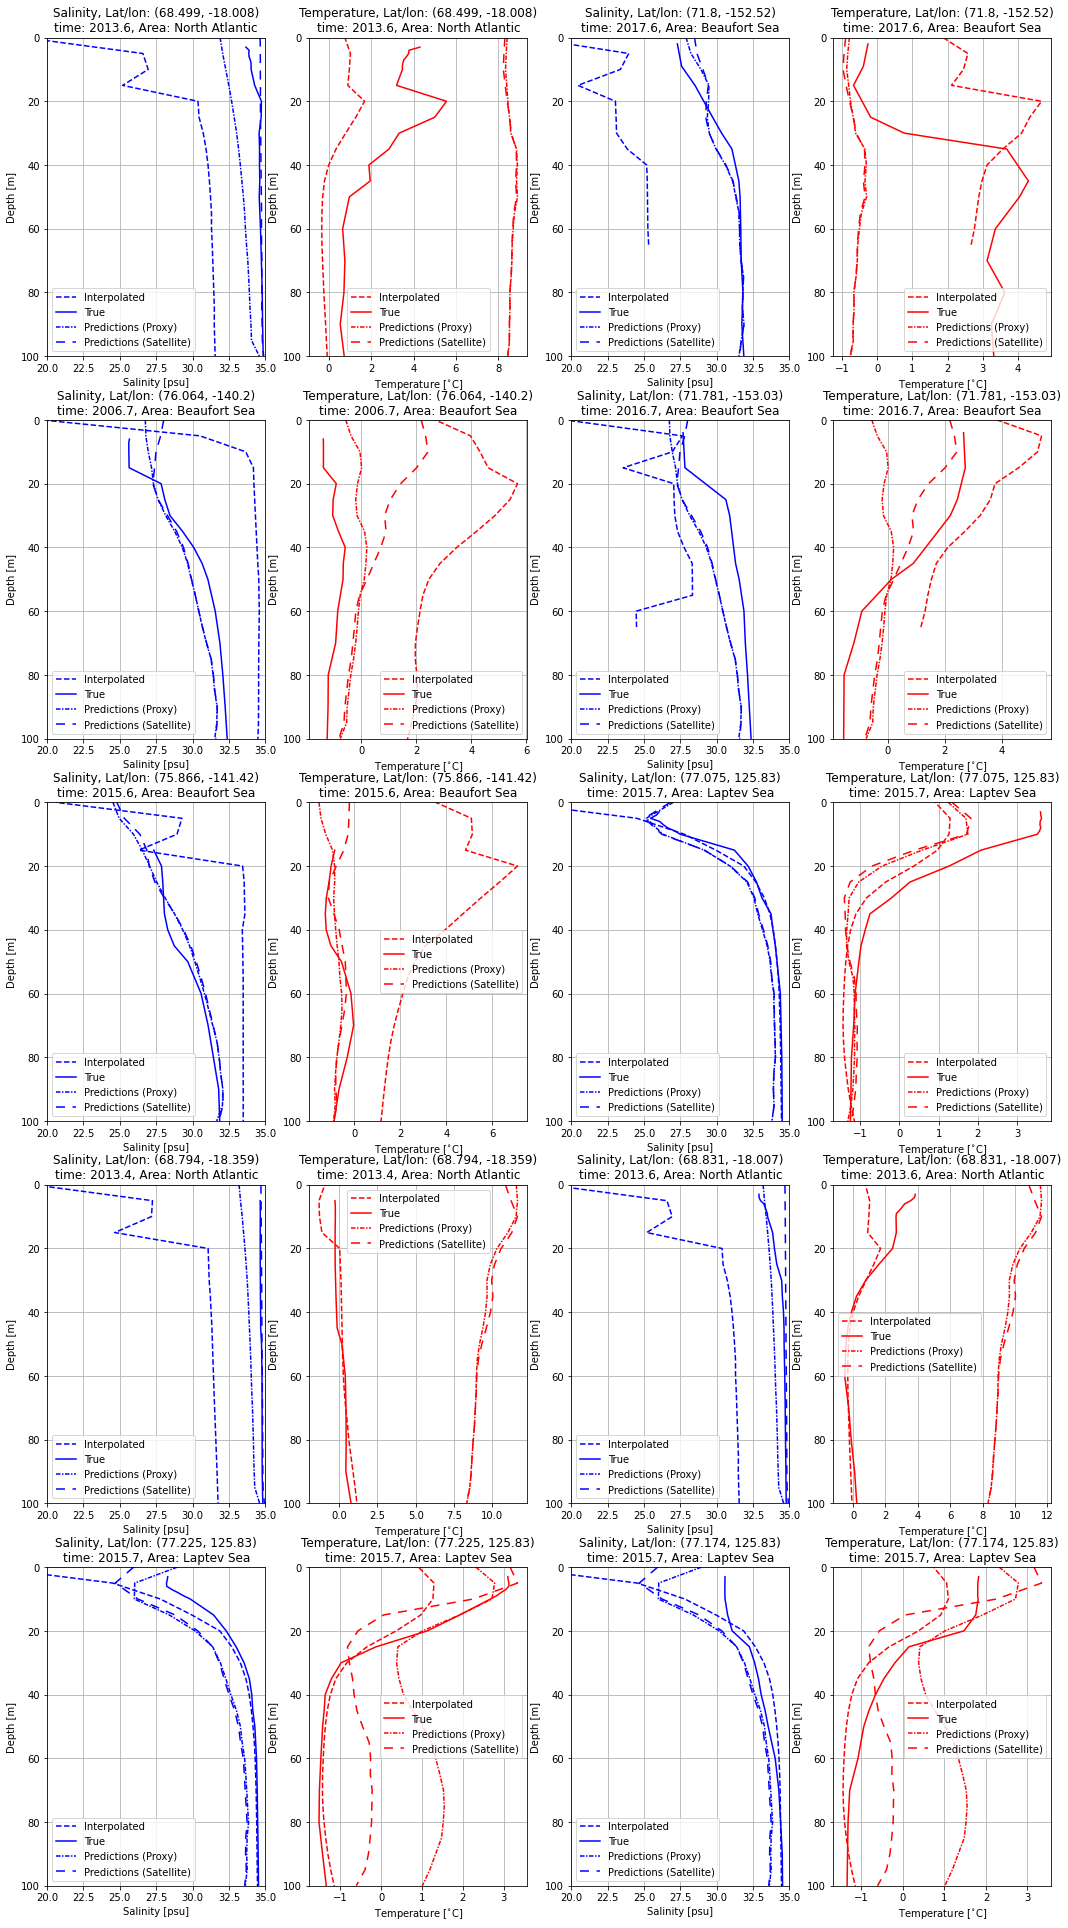

In [143]:
depths = np.arange(0, 105, 5)
fig, axs = plt.subplots(len(profiles)//2, 4, figsize=(18,34))
for i, ((key, profile), area_title, axe) in enumerate(zip(profiles.items(), idx_to_model, axs.reshape(-1,2))):
    area = area_title.replace('_', ' ').title()
    salinity_data = out_data['Salinity'][area]
    salinity_satellite_data = out_scaled_data['Salinity'][area]
    temperature_data = out_data['Temperature'][area]
    temperature_satellite_data = out_scaled_data['Temperature'][area]
    
    axe1, axe2 = axe[0], axe[1]
    
    # Salinity
    axe1.plot(profile['intp'][:,2][::-1], profile['intp'][:,0][::-1], 'b--', label="Interpolated")
    axe1.plot(profile['true'][:,2][::-1], profile['true'][:,0][::-1], 'b', label="True")
    axe1.plot(salinity_data[i // 2], depths, 'b', linestyle=(0, (3, 1, 1, 1)), label="Predictions (Proxy)")
    axe1.plot(salinity_satellite_data[i // 2], depths, 'b', linestyle=(0, (6, 5)), label="Predictions (Satellite)")
    axe1.legend()
    axe1.grid()
    axe1.set_ylim([100, 0])
    axe1.set_xlim([20, 35])
    axe1.set_ylabel("Depth [m]")
    axe1.set_xlabel("Salinity [psu]")
    axe1.set_title(f"Salinity, Lat/lon: {profile['lat'], profile['lon']}\ntime: {profile['time']}, Area: {area}")
    
    # Temperature
    axe2.plot(profile['intp'][:,1][::-1], profile['intp'][:,0][::-1], 'r--', label="Interpolated")
    axe2.plot(profile['true'][:,1][::-1], profile['true'][:,0][::-1], 'r', label="True")
    axe2.plot(temperature_data[i // 2], depths, 'r', linestyle=(0, (3, 1, 1, 1)), label="Predictions (Proxy)")
    axe2.plot(temperature_satellite_data[i // 2], depths, 'r', linestyle=(0, (6, 5)), label="Predictions (Satellite)")
    axe2.legend()
    axe2.grid()
    axe2.set_ylim([100, 0])
    axe2.set_xlim([-3, 8])
    axe2.set_ylabel("Depth [m]")
    axe2.set_xlabel(r"Temperature [$^{\circ}$C]")
    axe2.set_title(f"Temperature, Lat/lon: {profile['lat'], profile['lon']}\ntime: {profile['time']}, Area: {area}")
plt.show()